Exercise-2 Task-1

 Implement vector differentiation similar to numpy diff function using shared memory.

In [2]:
!pip install pycuda

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 14.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.6/70.6 kB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 12.4 MB/s eta 0:00:00
  Created wheel for pycuda: filename=pycuda-2024.1-cp310-cp310-linux_x86_64.whl size=661205 sha256=f07629347493501c0f5239704e60d8b723368e6ba9387be297a5951b0a93f3fb
  Stored in directory: /root/.cache/pip/wheels/12/34/d2/9a349255a4eca3a486d82c79d21e138ce2ccd90f414d9d72b8
Successfully built pycuda


Import essentials

In [ ]:
import numpy as np


In [ ]:
import pycuda.driver as cuda

import pycuda.autoinit
from pycuda.compiler import SourceModule


Define Cuda kernel for vector differentiation

In [ ]:
diff_kernel = SourceModule("""
#define BLOCK_SIZE 1024

__global__ void diff_vector_kernel(const double* input, double* output, int size)
{
    __shared__ double shared_data[BLOCK_SIZE];

    int tid = threadIdx.x;
    int idx = blockIdx.x * blockDim.x + tid;

    // Load data into shared memory
    if (idx < size)
        shared_data[tid] = input[idx];
    __syncthreads();

    // Compute differences and store in output array
    if (idx < size - 1)
        output[idx] = shared_data[tid + 1] - shared_data[tid];
}
""").get_function("diff_vector_kernel")

Define an input vector
Allocate GPU memory
Copy input vector to GPU
Define block and grid dimensions
Launch the kernel


In [ ]:
#define the diff_vector_gpu function
def diff_vector_gpu(input_vector):
    size = len(input_vector)
    output_vector = np.empty(size - 1, dtype=np.float64)

    # Allocation of GPU memory
    #both input and output gpu
    input_gpu = cuda.mem_alloc_like(input_vector)
    output_gpu = cuda.mem_alloc(output_vector.nbytes)

    # Let's copy the input vector to GPU
    cuda.memcpy_htod(input_gpu, input_vector)

    # Define block size and Grid size
    #block size=1024
    block_size = 1024
    grid_size = (size + block_size - 1) // block_size

    # Now launch the kernel diff_kernel()
    diff_kernel(input_gpu, output_gpu, np.int32(size), block=(block_size, 1, 1), grid=(grid_size, 1, 1))

    # Now copy the result back to cpu which returns the output vector afterwards
    cuda.memcpy_dtoh(output_vector, output_gpu)

    return output_vector

Let's try an example

Random vector inputs and test

In [ ]:
if __name__ == "__main__":
    # Let's try with a random vector
    input_vector = np.random.randn(1000)

    # result_gpu returns result after GPU differentiatation
    result_gpu = diff_vector_gpu(input_vector)

    # num py is used for comparison
    #Compute vector differentiation
    result_cpu = np.diff(input_vector)

    # Test the result and verify
    np.testing.assert_allclose(result_cpu, result_gpu, rtol=1e-5, atol=1e-8)
      #results match when verification is successful
    print("Results match!")

      # Display the original random vector taken as input
    print("Original Vector:")
    print(input_vector)
     #Display generated vector by doing diferentiation
    print("\nDifferentiated Vector:")
    print(result_gpu)

Results match!
Original Vector:
[ 1.41827209e+00 -2.43028579e-01 -8.92567951e-02  4.13652675e-01
 -8.71983779e-01  6.82111660e-01  6.71415431e-01 -1.32312900e+00
  2.38239366e-01  2.51742761e-01 -1.26670692e+00 -1.09986515e+00
  1.59509126e+00 -9.11059223e-01 -8.08925941e-01  8.64981172e-01
 -1.08479842e-02 -2.13228535e-01  5.68266642e-01  4.26397149e-01
  8.89928294e-01  1.44226529e-01 -1.47487983e+00 -3.91129926e-01
 -1.24633058e+00  2.45166218e-01 -1.22261561e+00  8.33909866e-01
  1.17322399e-01  1.16468861e-03  3.89212176e-01  3.59761739e-01
  6.37452676e-01 -1.13243874e+00 -6.81663701e-01  7.18563604e-01
 -1.78114779e+00 -2.25039257e+00 -1.09068027e-01 -7.48429507e-01
  7.15091165e-01 -1.44606572e+00  4.00922648e-01 -9.75748206e-03
  1.38312844e-01  9.37609373e-01  5.40261223e-01  4.05706115e-01
 -5.67766244e-01 -1.65145596e+00  1.27353035e+00 -1.50224683e+00
 -8.70936926e-01 -1.04241684e+00  8.36940523e-01 -6.96515269e-01
  3.50721483e-01  2.05824498e+00 -1.30343079e-01  9.497995

Task2

Implement the three reduction models presented in the lectures. Time their performance against different vector sizes. Execution times can vary between executions, so run them for example 100 times and take the average time.

In [3]:
import numpy as np
import pycuda.driver as cuda
import pycuda.autoinit
from pycuda.compiler import SourceModule

Import timeit and plot

In [4]:
import timeit
import matplotlib.pyplot as plt

Define Kernel using source module

In [5]:
#interleaved function
modd_interleave = SourceModule("""
__global__ void interleaved_reduction(double* xs, int stride)
{
  int index = blockIdx.x * blockDim.x + threadIdx.x;
  int index_result = index & (2 * stride - 1);
  if (index_result == 0)
  {
    xs[index] += xs[index + stride];
  }
}
""")

Define sequential using the SourceModule functionality.

In [6]:
#sequantial
modd_sequential = SourceModule("""
__global__ void sequential_reduction(double* xs, int stride, int size)
{
  int index = blockIdx.x * blockDim.x + threadIdx.x;
  if(index + stride < size)
  {
    xs[index] += xs[index + stride];
  }
}
""")

Define interleaved GPU
Allocate GPU memory
Set up block and grid dimensions

In [7]:
#define interleaved function in GPU
def function_interleave_GPU(a, vector_size):
    # Allocate GPU memory and copy data
    a_gpu = cuda.mem_alloc(a.nbytes)
    cuda.memcpy_htod(a_gpu, a)

    # Block and grid dimension for calculation
    numThreadsPerBlock = 1024
    numBlocks = (vector_size + numThreadsPerBlock - 1) // numThreadsPerBlock

    # Now call the GPU kernel
    #get the interleaved reduction kernel
    interleaved_reduction_kernel = modd_interleave.get_function("interleaved_reduction")
    stride = 1
    while stride < vector_size:
        interleaved_reduction_kernel(a_gpu, np.int32(stride), block=(numThreadsPerBlock, 1, 1), grid=(numBlocks, 1, 1))
        stride *= 2

    # Copy the result got back to the CPU
    result = np.empty_like(a)
    cuda.memcpy_dtoh(result, a_gpu)

    # After copying back from GPU to CPU, free the GPU memory
    cuda.mem_free(a_gpu)

    return result  #resturn the result

Define sequential approach through a function

In [8]:
def function_sequential_GPU(a, vector_size):
    # Allocate GPU memory
    a_gpu = cuda.mem_alloc(a.nbytes)
    #copy data
    cuda.memcpy_htod(a_gpu, a)

    # Block and grid dimension initialization
    numThreadsPerBlock = 1024
    numBlocks = (vector_size + numThreadsPerBlock - 1) // numThreadsPerBlock

    # Now call the GPU kernel for sequential reduction
    sequential_reduction_kernel = modd_sequential.get_function("sequential_reduction")
    stride = vector_size // 2
    while stride > 0:
        sequential_reduction_kernel(a_gpu, np.int32(stride), np.int32(vector_size), block=(numThreadsPerBlock, 1, 1), grid=(numBlocks, 1, 1))
        stride //= 2

    # After the sequential reduction is calculated copy the result back to CPU
    result = np.empty_like(a)
    cuda.memcpy_dtoh(result, a_gpu)

    # Make the GPU memory free and return result
    cuda.mem_free(a_gpu)

    return result

Define interleaved function GPU and interleaved reduction

In [9]:
def function_interleave_GPU(a, vector_size):
    # Copy data to GPU and transfer
    a_gpu = cuda.to_device(a)

    # Block and grid dimension set up
    numThreadsPerBlock = 1024
    numBlocks = (vector_size + numThreadsPerBlock - 1) // numThreadsPerBlock

    # Now call the GPU kernel for interleaved reduction kernel
    interleaved_reduction_kernel = modd_interleave.get_function("interleaved_reduction")
    stride = 1
    while stride < vector_size:
        interleaved_reduction_kernel(a_gpu, np.int32(stride), block=(numThreadsPerBlock, 1, 1), grid=(numBlocks, 1, 1))
        stride *= 2

    # Copy the result back to the CPU
    result = np.empty_like(a)
    cuda.memcpy_dtoh(result, a_gpu)

    return result

Define sequential GPU function and sequential reduction kernel

In [10]:
def function_sequential_GPU(a, vector_size):
    # After function definition copy data to GPU
    a_gpu = cuda.to_device(a)

    # Block and Grid dimension set up
    numThreadsPerBlock = 1024
    numBlocks = (vector_size + numThreadsPerBlock - 1) // numThreadsPerBlock

    # Call the GPU kernel for sequential reduction kernel
    sequential_reduction_kernel = modd_sequential.get_function("sequential_reduction")
    stride = vector_size // 2
    while stride > 0:
        sequential_reduction_kernel(a_gpu, np.int32(stride), np.int32(vector_size), block=(numThreadsPerBlock, 1, 1), grid=(numBlocks, 1, 1))
        stride //= 2

    # Result transfered back to the CPU
    result = np.empty_like(a)
    cuda.memcpy_dtoh(result, a_gpu)

    return result


Import Time

In [11]:
import time

Use for example 2^10, 2^13, 2^16, 2^20 and 2^22 values and plot them into same graph.

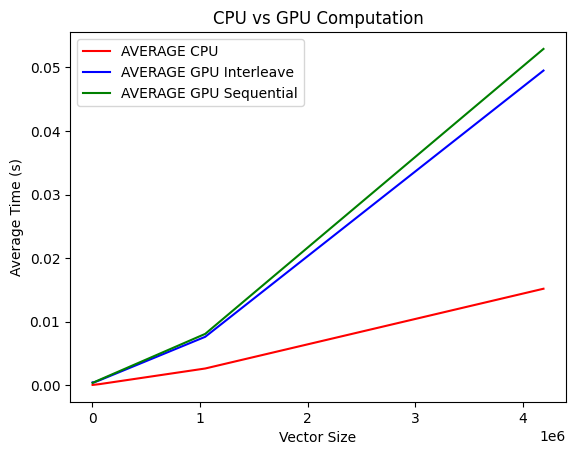

In [12]:
#Now implement the required task
#Given values stored in a vector
example_vector = [2 ** 10, 2 ** 13, 2 ** 16, 2 ** 20, 2 ** 22]
#number of iterations for example 100
iterations = 100
AVG_times_GPU_interleave = []
AVG_times_GPU_sequential = []
AVG_times_CPU = []

# Perform the given task
#for look for the vector size list
for vector_size in example_vector:
    seq_times_GPU_interleave = []
    seq_times_GPU_sequential = []
    seq_times_CPU = []
    value_type = float
    a = np.random.randn(vector_size)

    for _ in range(iterations):
        # CPU Calculation end times and sequence times
        start_time = time.time()
        a = a.astype(value_type)
        a_cpu = np.sum(a)
        end_time = time.time()
        seq_times_CPU.append(end_time - start_time)

        # Calculate GPU Interleaved
        start_time = time.time()
        result = function_interleave_GPU(a, vector_size)
        end_time = time.time()
        seq_times_GPU_interleave.append(end_time - start_time)

        # Sequential calculation of GPU
        start_time = time.time()
        result = function_sequential_GPU(a, vector_size)
        end_time = time.time()
        seq_times_GPU_sequential.append(end_time - start_time)

    # Now calculate the average times
    #Average times in CPU
    #Average times GPU interleaved
    #Average times GPU_sequential
    AVG_times_CPU.append(sum(seq_times_CPU) / iterations)
    AVG_times_GPU_interleave.append(sum(seq_times_GPU_interleave) / iterations)
    AVG_times_GPU_sequential.append(sum(seq_times_GPU_sequential) / iterations)

# Plot all the computed results in a figure
#Average times in CPU, Average times in GPU and Average times in GPU sequential is plotted
plt.plot(example_vector, AVG_times_CPU, label='AVERAGE CPU', color='red')
plt.plot(example_vector, AVG_times_GPU_interleave, label='AVERAGE GPU Interleave', color='blue')
plt.plot(example_vector, AVG_times_GPU_sequential, label='AVERAGE GPU Sequential', color='green')

# labels and titles
#on X axis vector size, y axis Average time
plt.xlabel('Vector Size')
plt.ylabel('Average Time (s)')
plt.title('CPU vs GPU Computation')
plt.legend()

# Show the plot of the Average times
plt.show()

Task-3

Implement Sequential reduction with shared memory. Add the performance to the same plot used in the previous task.

Define CUDA kernel

In [14]:
import pycuda.driver as cuda
import pycuda.autoinit
from pycuda.compiler import SourceModule
import numpy as np
import matplotlib.pyplot as plt
import time

In [15]:
#Let's define CUDA KerNel
# Define the CUDA kernel for sequential reduction with shared memory
mod_shared = SourceModule("""
    extern "C"
    __global__ void sequential_reduction_shared(double* xs, int size, double* result)
    {
        extern __shared__ double shared_xs[];

        int tid = threadIdx.x;
        int index = blockIdx.x * blockDim.x + tid;

        // Load data into shared memory
        if (index < size)
        {
            shared_xs[tid] = xs[index];
        }
        else
        {
            shared_xs[tid] = 0.0;
        }

        __syncthreads();

        #sequential reduction in shared memory

        // Perform sequential reduction in shared memory
        for (int stride = 1; stride < blockDim.x; stride *= 2)
        {
            int index = 2 * stride * tid;
            if (index < blockDim.x)
            {
                shared_xs[index] += shared_xs[index + stride];
            }

            __syncthreads();
        }

        // Store the result in global memory
        if (tid == 0)
        {
            result[blockIdx.x] = shared_xs[0];
        }
    }
""")

Define a function for sequential reduction using shared memory

In [18]:
#define sequential function for shared GPU
def function_sequential_shared_GPU(a, vector_size):
    # Copy the data into GPU
    a_gpu = cuda.to_device(a)

    # Set up Block and Grid dimension and calculate number of blocks
    #number of thread per block is defined 1024
    numThreadsPerBlock = 1024
    numBlocks = (vector_size + numThreadsPerBlock - 1) // numThreadsPerBlock

    # Now Calculate the size of the shared memory
    shared_mem_size = numThreadsPerBlock * a.itemsize

    # Now call the GPU kernel for sequential reduction with shared memory
    sequential_reduction_shared_kernel = mod_shared.get_function("sequential_reduction_shared")
    result_gpu = cuda.mem_alloc(numBlocks * a.itemsize)
     #Get the sequential reduction shared kernel
    sequential_reduction_shared_kernel(a_gpu, np.int32(vector_size), result_gpu, block=(numThreadsPerBlock, 1, 1), grid=(numBlocks, 1, 1), shared=shared_mem_size)

    # Now let's copy the result back to CPU
    result = np.empty(numBlocks, dtype=a.dtype)
    cuda.memcpy_dtoh(result, result_gpu)

  #Managed memory doesn't require to be freed

    return result.sum()

# implement with the given values and store them in a vector
vector_sizes = [2**10, 2**13, 2**16, 2**20, 2**22]
num_iterations = 100 #take 100 iterations and calculate average time
avg_seq_times_shared = []

for vector_size in vector_sizes:
    seq_times_shared = []

    a = np.random.randn(vector_size).astype(np.float64)
#for loop for time estimation in number of iterations
    for _ in range(num_iterations):
        start_time = time.time()
        result = function_sequential_shared_GPU(a, vector_size)
        end_time = time.time()
        seq_times_shared.append(end_time - start_time)

        #Average sequential time in shared memory calculated

    avg_seq_time_shared = sum(seq_times_shared) / num_iterations
    avg_seq_times_shared.append(avg_seq_time_shared)



Let's plot the results

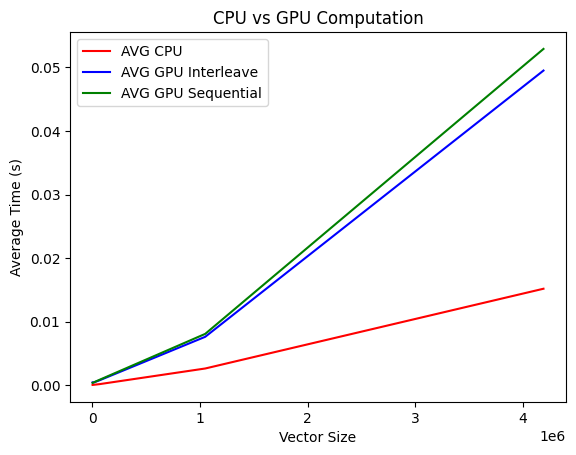

In [19]:
# Let's plot the Average times in CPU, GPU interleaved and GPU sequential
plt.plot(example_vector, AVG_times_CPU, label='AVG CPU', color='red')
plt.plot(example_vector, AVG_times_GPU_interleave, label='AVG GPU Interleave', color='blue')
plt.plot(example_vector, AVG_times_GPU_sequential, label='AVG GPU Sequential', color='green')

# label the plots and assign titles
plt.xlabel('Vector Size')
plt.ylabel('Average Time (s)')
plt.title('CPU vs GPU Computation')
plt.legend()

# Show the plot of the Average times
plt.show()